In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [2]:
import utils
from model import DSFANet

In [3]:
def main(X, Y, GT, diff):

    train_num = 2000
    max_iters = 2000
    lr = 1e-4

    index = np.argsort(diff)
    XData = X[index[0:train_num], :]
    YData = Y[index[0:train_num], :]

    inputX = tf.placeholder(dtype=tf.float32, shape=[None, X.shape[-1]])
    inputY = tf.placeholder(dtype=tf.float32, shape=[None, Y.shape[-1]])
    model = DSFANet(num=train_num)
    loss = model.forward(X=inputX, Y=inputY)

    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    init = tf.global_variables_initializer()

    gpu_options = tf.GPUOptions(allow_growth=True)
    conf = tf.ConfigProto(gpu_options=gpu_options)
    sess = tf.Session(config=conf)

    sess.run(init)

    train_loss = np.zeros(max_iters)

    for k in range(max_iters):

        _, train_loss[k] = sess.run([optimizer, loss], feed_dict={inputX: XData, inputY: YData})

        if k % 100 == 0:
            print('iter %4d, loss is %.4f' % (k, train_loss[k]))

    XTest, YTest = sess.run([model.X_, model.Y_], feed_dict={inputX: X, inputY: Y})

    sess.close()

    X_trans, Y_trans = utils.SFA(XTest, YTest)

    diff = X_trans-Y_trans
    diff = diff / np.std(diff, axis=0)

    plt.imsave('DSFAdiff.png', (diff**2).sum(axis=1).reshape(GT.shape), cmap='gray')

    bin = KMeans(n_clusters=2).fit((diff**2).sum(axis=-1, keepdims=True)).labels_
    #bin = KMeans(n_clusters=2).fit(diff).labels_
    plt.imsave('DSFACD.png', bin.reshape(GT.shape), cmap='gray')
    #diff = abs(diff)
    #plt.imsave('DSFAcolor.png',(diff/diff.max()).reshape(GT.shape[0], GT.shape[1],3))

    print(accuracy_score(GT.reshape(-1, 1)/255, bin))
    print(accuracy_score(GT.reshape(-1, 1)/255, 1-bin))

    return True


In [4]:
if __name__ == '__main__':
    
    X, Y, GT = utils.load_dataset()
    diff = utils.cva(X=X, Y=Y)
    plt.imsave('cva_diff.png', np.reshape(diff, GT.shape), cmap='gray')
    main(X, Y, GT, diff)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



iter    0, loss is 30.3763
iter  100, loss is 5.6784
iter  200, loss is 4.0765
iter  300, loss is 3.4181
iter  400, loss is 3.0290
iter  500, loss is 2.7616
iter  600, loss is 2.5610
iter  700, loss is 2.4010
iter  800, loss is 2.2675
iter  900, loss is 2.1521
iter 1000, loss is 2.0498
iter 1100, loss is 1.9571
iter 1200, loss is 1.8714
iter 1300, loss is 1.7910
iter 1400, loss is 1.7147
iter 1500, loss is 1.6417
iter 1600, loss is 1.5718
iter 1700, loss is 1.5048
iter 1800, loss is 1.4406
iter 1900, loss is 1.3792
0.9498579532724519
0.0501420467275481


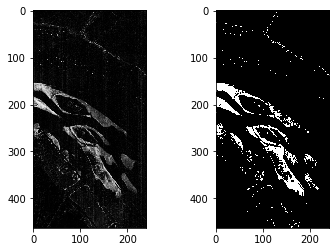

In [5]:
DSFAdiff = plt.imread('DSFAdiff.png')
DSFACD = plt.imread('DSFACD.png')
plt.subplot('121')
plt.imshow(DSFAdiff)
plt.subplot('122')
plt.imshow(DSFACD)
plt.show()